In [1]:
import pandas as pd
import numpy as np
import glob
import os
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from datetime import datetime as dt
import unidecode
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion, make_union
from sklearn.multiclass import OneVsRestClassifier
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
import string

import re
import pickle

from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 

from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

from scipy.sparse import hstack
from scipy.special import logit, expit

# from my_nmf import NMF
# from helpers import build_text_vectorizer, hand_label_topics, analyze_article

plt.style.use('seaborn')
# os.chdir("data")

In [2]:
file = 'data/comments.csv'
df = pd.read_csv(file, names = ['Text', 'ID', 'Subreddit', 'meta', 'Time', 'Username', 'Upvotes', 'Downvotes', 'Author_link_karma', 'Author_Comment_Karma','Author_has_gold?'], parse_dates =True, encoding = 'utf-8')


In [3]:
df2 = df.copy()

In [4]:
df_entertainment = df.dropna(axis =0).loc[df['meta']== 'entertainment']
# df_entertainment.Text

# Proper Pipeline, no alaska

In [506]:
# v's are randomly being deleted from my text data in an unpredictable way, is there any way to stop that?

# array1

In [5]:
def clean_urls(array):
    lst = []
    for string in array:
#         print(string)
        if string > re.sub(r'(https|http)? : \/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', string, flags=re.MULTILINE):
            string = re.sub(r'(https|http)? : \/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', string, flags=re.MULTILINE)
#             print(string)
            string = re.sub(r'v = () ', '', string, flags = re.MULTILINE)
            lst.append(string)
        else: 
            string = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', string, flags=re.MULTILINE)
            lst.append(string)
    return lst
# test
tokelems = clean_urls(df_entertainment.Text.values)
# cleaned_urls
# type(cleaned_urls[1])

In [6]:
s_stop = set(stopwords.words())
print(len(s_stop))
new_stops = ['2015ref','publisherspage190ref','volume9', 'issue2','005', '1671', '2015', 'jpgthumbemerg', 'jpgthumbrightth', 'logo', 'page7','logo.png','2015.ref', 'nameleaf200kcit','ref', '005.jpgthumbrightth', 'whose', 'kind','png', 'jpg', 'wiktionaryzero', 'wiktionaryzero0', 'wiktionaryzero0', 'articlesquantum','0supsup', '0refcit', '1-3', 'redirectzero', '.', ',', 'nameleaf200k2cit', 'wiktionari', 'namecarb01cit','-', 'filezero', 'mvaramvarxmvari', 'page98','datemfyes1915228', 'year1989ref', '1671.jpgthumbemerg', 'refimprovedatemay','ligatureligatur', 'pppc1expiry2144', 'wiktionary','wiktionary0', 'n','improvedateoctob','baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'onların', 'printr', 'sekurang', 'setidak', 'tama', 'tidaknya', 'δι', 'арбаң', 'арсалаң', 'афташ', 'бай', 'бале', 'баски', 'батыр', 'баҳри', 'болои', 'бүгжең', 'бұтыр', 'валекин', 'вақте', 'вой', 'вуҷуди', 'гар', 'гарчанде', 'далаң', 'даме', 'ербелең', 'жалт', 'жұлт', 'карда', 'кошки', 'куя', 'күңгір', 'кӣ', 'магар', 'майлаш', 'митың', 'модоме', 'нияти', 'онан', 'оре', 'паһ', 'рӯи', 'салаң', 'сар', 'сұлаң', 'сұрт', 'тарбаң', 'тразе', 'ту', 'тыржың', 'тұрс', 'хом', 'хуб', 'чаро', 'чи', 'чун', 'чунон', 'шарте', 'шұңқ', 'ыржың', 'қадар', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ', 'қош', 'қызараң', 'құйқаң', 'құлт', 'құңқ', 'ұрс', 'ҳай', 'ҳамин', 'ҳатто', 'ҳо', 'ҳол', 'ҳолате', 'әттеген', 'ӯим', 'अक', 'अग', 'अझ', 'अन', 'अर', 'आजक', 'आत', 'आद', 'आफ', 'आय', 'ईक', 'उद', 'उनक', 'उनल', 'उह', 'एउट', 'एन', 'कog', 'कत', 'कम', 'कस', 'कसर', 'कह', 'गत', 'गय', 'गर', 'चम', 'छन', 'जत', 'जबक', 'जस', 'जसक', 'जसब', 'जसम', 'जसल', 'जह', 'तत', 'तथ', 'तदन', 'तप', 'तवम', 'नज', 'नत', 'नभन', 'नय', 'पक', 'पछ', 'पन', 'पय', 'पर', 'पष', 'पह', 'बन', 'बर', 'भएक', 'भय', 'भव', 'मल', 'यत', 'यथ', 'यद', 'यप', 'यसक', 'यसपछ', 'यसब', 'यसर', 'यह', 'रण', 'रत', 'रमश', 'रह', 'लस', 'वर', 'सक', 'सट', 'सध', 'सपछ', 'सब', 'सम', 'सर', 'सह', 'हन', 'हर', 'हरण', 'ἀλλ']
for i in new_stops:
    s_stop.add(i)
    
    
print(len(s_stop))


6255
6471


In [7]:
punctuations = '''.!=-()[]{};:"|\<>/?@#$%^&*_~'''
replace = '{}'.format('\n')
lst = []

test_strings = ['James ran ForWard from the https:// youtube.com v asfhabjf v asvjdakbfakdfasdfbasdfadfsasfadga %666^^ 32$']
test_strings2 = df_entertainment.Text.values[:2]
# print(test_strings2)

def base_clean_up(strings):
    new_strings = [] 
    for i in strings:
#         i = clean_urls(i)
#         print(i)
        i = i.lower()
#         print(i)
        i = unidecode.unidecode(i)
#         print(i)
        no_punct = ""
        for word in i.split():
            
            word = re.sub(r'[^\w\s]','',word)
            if len(word) > 20:
                word = ""
            no_punct += f'{word} '
        new_strings.append(no_punct)
#         print(no_punct)
    return new_strings



# # test check
# clean_test = base_clean_up(test_strings2)
# print(clean_test)
# check using df
tokelems = base_clean_up(tokelems)  
# base_clean_up1
# clean_test

In [8]:
def tokenizer(strings):
        lst = []
        for i in strings:
            tokens = [word for word in i.split(" ") if word not in s_stop]
            lst.append(tokens)
        return lst

# # test tokenizer 
tokelems = tokenizer(tokelems)
# print(test_tokes)
#     lst.append(no_punct)
# df_entertainment.Text = lst

In [9]:
def lemmatization(tokens):
#     for i in tokens:
    
    lems = [[lemmatizer.lemmatize(word) for word in sent] for sent in tokens]
    return lems
tokelems = lemmatization(tokelems)


In [10]:
df_entertainment['Tokelems'] = tokelems
df_entertainment

,Text,ID,Subreddit,meta,Time,Username,Upvotes,Downvotes,Author_link_karma,Author_Comment_Karma,Author_has_gold?,Tokelems
1446458,i can not wait to see him whoop some intergala...,d02nuw8,movies,entertainment,1.455673e+09,cmonster1697,1.0,0.0,488.0,8426.0,0.0,"[wait, see, whoop, intergalactic, alien, butt,..."
1446459,amazing cinematographer. one of the best to ev...,d02q51i,movies,entertainment,1.455676e+09,BrodoFagginsIsMyName,1.0,0.0,1.0,457.0,0.0,"[amazing, cinematographer, best, ever, , ]"
1446463,you 've finally had your life changed .,d02uuym,movies,entertainment,1.455684e+09,BrodoFagginsIsMyName,3.0,0.0,1.0,457.0,0.0,"[finally, life, changed, , ]"
1446464,that is awesome ! thanks !,d02ftgc,movies,entertainment,1.455661e+09,JeopardyThis,3.0,0.0,1.0,-7.0,0.0,"[awesome, , thanks, , ]"
1446465,"that tom cruise 's character , john anderton ,...",465qz3,movies,entertainment,1.455672e+09,tangowhiskey33,16.0,0.0,7346.0,6138.0,0.0,"[tom, cruise, character, , john, anderton, , k..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1826308,i love it ! ! !,d026lj4,harrypotter,entertainment,1.455648e+09,elbowsss,2.0,0.0,2212.0,8637.0,1.0,"[love, , , , ]"
1826309,you are the type of ra i hope i can be if i ma...,d02qfaf,harrypotter,entertainment,1.455677e+09,DEP61,2.0,0.0,5581.0,13488.0,0.0,"[type, ra, hope, manage, get, selected, , curr..."
1826310,this was my bulletin board for the month too :...,d02rem2,harrypotter,entertainment,1.455678e+09,laneebird,2.0,0.0,43.0,8.0,0.0,"[bulletin, board, month, , p, ]"
1826311,that 's so excellent ! i would be so pleased t...,d02ecuj,harrypotter,entertainment,1.455659e+09,GoodniteMush,1.0,0.0,1.0,681.0,0.0,"[excellent, , would, pleased, find, first, day..."


In [35]:
dummiezed = pd.get_dummies(df_entertainment,columns = ['Subreddit'])
dummiezed


,Text,ID,meta,Time,Username,Upvotes,Downvotes,Author_link_karma,Author_Comment_Karma,Author_has_gold?,Tokelems,Subreddit_anime,Subreddit_comicbooks,Subreddit_harrypotter,Subreddit_movies,Subreddit_music,Subreddit_starwars
1446458,i can not wait to see him whoop some intergala...,d02nuw8,entertainment,1.455673e+09,cmonster1697,1.0,0.0,488.0,8426.0,0.0,"[wait, see, whoop, intergalactic, alien, butt,...",0,0,0,1,0,0
1446459,amazing cinematographer. one of the best to ev...,d02q51i,entertainment,1.455676e+09,BrodoFagginsIsMyName,1.0,0.0,1.0,457.0,0.0,"[amazing, cinematographer, best, ever, , ]",0,0,0,1,0,0
1446463,you 've finally had your life changed .,d02uuym,entertainment,1.455684e+09,BrodoFagginsIsMyName,3.0,0.0,1.0,457.0,0.0,"[finally, life, changed, , ]",0,0,0,1,0,0
1446464,that is awesome ! thanks !,d02ftgc,entertainment,1.455661e+09,JeopardyThis,3.0,0.0,1.0,-7.0,0.0,"[awesome, , thanks, , ]",0,0,0,1,0,0
1446465,"that tom cruise 's character , john anderton ,...",465qz3,entertainment,1.455672e+09,tangowhiskey33,16.0,0.0,7346.0,6138.0,0.0,"[tom, cruise, character, , john, anderton, , k...",0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1826308,i love it ! ! !,d026lj4,entertainment,1.455648e+09,elbowsss,2.0,0.0,2212.0,8637.0,1.0,"[love, , , , ]",0,0,1,0,0,0
1826309,you are the type of ra i hope i can be if i ma...,d02qfaf,entertainment,1.455677e+09,DEP61,2.0,0.0,5581.0,13488.0,0.0,"[type, ra, hope, manage, get, selected, , curr...",0,0,1,0,0,0
1826310,this was my bulletin board for the month too :...,d02rem2,entertainment,1.455678e+09,laneebird,2.0,0.0,43.0,8.0,0.0,"[bulletin, board, month, , p, ]",0,0,1,0,0,0
1826311,that 's so excellent ! i would be so pleased t...,d02ecuj,entertainment,1.455659e+09,GoodniteMush,1.0,0.0,1.0,681.0,0.0,"[excellent, , would, pleased, find, first, day...",0,0,1,0,0,0


In [63]:

sample_df = dummiezed.sample(n=10000)
sample_df

,Text,ID,meta,Time,Username,Upvotes,Downvotes,Author_link_karma,Author_Comment_Karma,Author_has_gold?,Tokelems,Subreddit_anime,Subreddit_comicbooks,Subreddit_harrypotter,Subreddit_movies,Subreddit_music,Subreddit_starwars
1663516,the information over at the harry potter wikia...,d01xfmt,entertainment,1.455635e+09,MacabreGoblin,15.0,0.0,95.0,191.0,1.0,"[information, harry, potter, wikia, , , , port...",0,0,1,0,0,0
1461781,"anyway , current classic music references : --...",d01bl2w,entertainment,1.455584e+09,Cleverly_Clearly,11.0,0.0,150869.0,165897.0,1.0,"[anyway, , current, classic, music, reference,...",1,0,0,0,0,0
1543507,as a former naval aviation radar technician......,d02cten,entertainment,1.455657e+09,Infinitopolis,4.0,0.0,15.0,35010.0,0.0,"[former, naval, aviation, radar, technicianhe,...",0,0,0,0,0,1
1555378,"jordy is n't here right now , so i 'm posting ...",45zj2b,entertainment,1.455579e+09,The-Sublimer-One,410.0,0.0,45938.0,151414.0,1.0,"[jordy, nt, right, , posting, instead, , , , ,...",1,0,0,0,0,0
1627055,this looks pretty cool,d01rsc4,entertainment,1.455620e+09,Andre_iC,3.0,0.0,11894.0,15570.0,0.0,"[look, pretty, cool, ]",0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1466464,"a little bit early for an april fool 's joke ,...",d02i923,entertainment,1.455664e+09,raffastafarian,2.0,0.0,707.0,70688.0,0.0,"[little, bit, early, april, fool, joke, , nt, , ]",0,0,0,1,0,0
1691586,freakin awesome,d01kvrw,entertainment,1.455599e+09,bryxy,1.0,0.0,4034.0,3004.0,0.0,"[freakin, awesome, ]",0,0,0,0,0,1
1732449,it 's funny how can see just from this sample ...,d00njz8,entertainment,1.455547e+09,sunset261,8.0,0.0,1.0,3265.0,0.0,"[funny, see, sample, footage, much, better, ci...",0,0,0,1,0,0
1811945,very cool. maybe a few ewoks could jazz up a f...,d02pxnf,entertainment,1.455676e+09,Debasers_Comics,1.0,0.0,7279.0,77501.0,1.0,"[cool, maybe, ewoks, could, jazz, future, wood...",0,0,0,0,0,1


In [64]:
sample_df = dummiezed.sample(n=10000)
sample_df
# lst = []
# for i in sample_df.Tokelems.values:
#     i = " ".join(i)
#     print(i)
#     lst.append(i)
# sample_df.Tokelems = lst


information harry potter wikia    portrait     headmaster portrait    indicates subject portrait nt maintain much   memory life reason headmaster portrait tend created early headmaster career cupboard painting learn retain information headmaster  since snape portrait nt added  even made  assuming  death  nt think would good representation snape would nt knowledge necessary teach class unless taught portrait potionsbut would could hire real live teach potion  
anyway  current classic music reference        part 1  phantom blood     dio named ronnie james dio  wang chen named  wang chung   ogre street named queen song  ogre battle   speedwagon named  reo speedwagon    zeppeli named  led zeppelin   named band    tarkus named emerson lake palmer album  tarkus   blueford named bill bruford  drummer  yes   tonpetty  tompeti tompetty however sub spell   named musician  tom petty    dire straitzo  named band  dire strait    doobie  named band  doobie brother    page  jones  plant  bonham  four

yare yare daze manjojo opening always soo goood  really like part star platinum smashing glass jotaro standing manlyoff egypt  
going make lot assumption please  order would bring lot intimate information lupin nt person blab know frankly would talked sirius prison  lily death snape would inconsolable know reacted  probably withdrawing  maybe even slipping front member order would showing emotion potter  remus  compassionate  caring  introspective perhaps quality couple scrap information dumbledore another member order character  overreaction  snape  people standard would controlled  fellow introvert sign could bit obvious  course remus know caught wind snape patronus changed bang  get odd sentence structure quote  retread time knowledge remus keeping information guarded either harry even snap sake odd place pause mention  thinking  hypothesizing using  anyway  throw away move subject along without dwelling believe giving plausible story partial truth know truth good person sparing two

obi  lord savior akagami  
lend goku strength 
meh thanks submitting list overall underwhelming solid film nt good surprised see incendies life others  
we3 grant morrison government decommissionmurder  rabbit heavily modified latest military hardware instinct animal kingdom go home make cry  amazing art  chosen mark millar jesus really back form 12 year old boy midwest  ocean warren elli future  frozen jupiter moon europa  discovered alien civilizationwhat secret may hold  orbiter warren elli homage nasa stand present  american space shuttle reappears miraculously year lost space pilot catatonic ship beenaltered really happened  hold humanity future  pride baghdad brian vaughn happened animal baghdad zoo american came  300 last 300 spartan last stand hot gate thermopylae epic wonderful art  halcyon mark millar world justice league likeheroesthe feared supercrimminal put jailand suddencrime rate start going  nonexistant caused  happens peace thing save hero  30 day night steve nile lon

pimp plate 
swear  dolores umbridge patronus dementor instead _  
problem thermal oscillator starkiller whole planet shielded  poe got inside oscillator chewie blew opening consider reasonably wellprotected  maybe could used redundancy  
addition everyone said  favorite critic   felt like something mark millar 10 year ago    frenchcanadian guy dialogue   poorly written someone french first language  probably  anyone speaking french   sounded like bkv randomly put stuff wrote english google translate  nt even bother correct conjugation mistake  
panty stocking garterbelt 
bookmarked website waiting san gon try get wife get birthday  amazing awesome awesome  
mudstick  slimy  boner  
 tried way resolve issue 
special bluray talked story board one tried existence  ennui  cracked  
movie really considered cult hit released like 2 month ago  
nt choose crash   
found front shot nt seem match pig like snout teeth 
500001 mean forgive yeezus  sinned  
read plot summary  say sound pretty good 

particular enjoy posting extra jpeged screenshots tumblr reposts  text link actual post copy paste image drag drop imgur 
make dredd 2 
dh nt released yet  lot people thought moment meant dumbledore actually follower voldemort  
mean besides singing jojo opening washing dish jojo pose every chance get  
animecom summer 2016 director  hiroshi hamasaki  texhnolyze  stein  gate  script  yuuko kakihara  chihayafuru  jewelpet sunshine  character design  nobuteru yuki  kid slope  space battleship yamato 2199  animation production  tm entertainment telecom animation film 
wow  amv suck  sync point ending defiantly exuberating  
actually disappointed asuka could almost pull win shindou might prodigy  seems pull crazy move  even teammate nt expect good asuka exhausted match still almost beat shindou   king king   misaki v shindou better imo could see went easy still lost  good fashion mean pro  student started sport competitive struggle  really disheartening see misaki match probably suck put m

really need hear two english people talk uneven american accent hour half  let use accent  fuck sake  p love wire stringer bell  wallace  barksdales shit  accent sounded  
    updating make list transparent 
nt remember 
batman  49 darth vader  16 deadpool amp  cable  split second  3 extraordinary xmen  7 
video editor school daily announcement put lucky star  haruhi  season 2  death parade background music 
damn  nt wan watch  
revenant dead floating wife hallucination  
time saw  seemed meant island  child true would mean luke nt  hunting  island  already knew fine logic  since may wanted keep secret wow  maybe found  
remember titan  
thing spice wolf would announced soon lol  
thing get better buddy keep looking forward force  always  
would another horrible boss sequel good original sequel horrible  
wait actually new footage  holy crap  
literally 2 hour logan murdering ninja wave ninja getting sliced diced 2 hour  okay  even settle 90 minute  long smoked cigar least 30 minute mo

went anime bought stuff 
good god  uncanny valley 
 death note spoiler    nt like psycho orphan used replace   
idol episode kyoukai kanata made show worth watching  
 _they turned   filthy   3d live action anime_    
  batman robin eternal  20    feel bad ca last issue know lot people dropped series  quite enjoy batfamily even art weak sometimes    martian manhunter  9    really wonder book impact rebirth  really enjoyed much wish people would pick book mr biscuit enjoyed    poison ivy  cycle life death  2    loving art enjoy good murder mystery support cool miniseries dc    superman  american alien  4    really liking series explores clark kent wonder book read trade constant change time art  maybe    power iron fist  1    really like david walker work might check like shaft series lot maybe get little comedy series  
quite easily fugliest comic book  cover  ever bought  
people either really hate movie love love 
sorry   still original collection  first one got 6 23   sentimental kn

felt lost otherworld storyline  six issue story right middle run nt lot consequence aside introducing recurring villain rest able read basic knowledge xchartacers  
definitely think mirror empire clone title   something  first order first order  somethings  mind   something  could either  advance   invasion  invades resistance  resists reign  reign rise  rise 
kurapika fought well waver gon get rekt next time fma train strong rip jordy 
laats best ship  
nt wait follow bumblebee journey transformer cybertron  vw beetle  chevy camaro epic  
fear  sense much strength  much strength  
brain thing super gross nice see joseph use hamon  holly   easily best character far season   nt like holly story  cool character turned plot device   see brushing someone else teeth nt weird  boy band formed get nice song go  
opening attack arikara native american revenant may hand shaking eye swelling little idea   film watch truly blew away nt get started bear mauling scene  
hyped   interesting see go  

watching harvest movie general zod idea wife agatha  
nt figure supposed astronomy  arithmancy  ancient rune good number symbol around edge astrological symbol planet  nt seem pattern make sense driving crazy whole time coloring  
mention beck drummer foo fighter  
think would bunch tiny colorful particle floating together shape person fear  tiny colorful particle together create  
looking forward bonus triplezero beetee story  meanwhile  discus rstarwarscomics 
damn hoping invincible would event focused title international would relatively self contained  sigh  
loving  
change mind week nt worry  
read book 8 14 came  nt retain whole lot first time  give harry lot detention show absolutely remorse actually physically abusing fact  often say need finished chapter ban  fred  george quidditch team completely forgot piss especially say decided go fudge mcgonagalldumbledore allowed gryffindor team reform say want broom confiscated put office  knew hated  relearning  
saying nt making osca

In [18]:
# doesnt really work

# def pipe1(array):
#     strings = clean_urls(array)
#     strings = base_clean_up(array1)    
#     tokens = tokenizer(strings)
#     lems = lemmatization(tokens)
#     return lems
# # # piped_1 = pipe1(array1)
# # piped_2 = pipe2(strings)
# # (piped_2
# new_vals = pipe1(df_entertainment.Text.values)


In [80]:
sample_df_test = dummiezed.sample(n=10000)
sample_df_test
lst = []
for i in sample_df_test.Tokelems.values:
    i = " ".join(i)
#     print(i)
    lst.append(i)
sample_df_test.Tokelems = lst
sample_df_test.Tokelems

1555212                                   punch got anime   
1784360    sex melodramatically upset bruce  fired   nt e...
1817009    regrettably kept information added hp world si...
1573780                                         hell bike   
1489956    kanon  2006   guy amnesia return hometown enco...
                                 ...                        
1759250                         mask come mind violent top  
1467169    last december  went see  star war  force awake...
1613453                             went anime bought stuff 
1552521    shamelessly reposting suggestion rstarwars thr...
1620067    biyori  renge learns ro ride bike  first seaso...
Name: Tokelems, Length: 10000, dtype: object

# RFC 
0. datacleaning
1. dummyize the subs for target
2. vectorizer.fit_transform(data.tokelems)
3. sparse array.toarray()
4. X is now my obs by terms matrix i get, y is dummied target
5. rfc time

In [41]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.965, min_df=.015, stop_words=new_stops)

In [84]:
# new variable name, rerun to test
vec_X_train= tfidf_vectorizer.fit_transform(sample_df['Tokelems']).toarray()

In [82]:
vec_X_test = tfidf_vectorizer.fit_transform(sample_df_test['Tokelems']).toarray()
vec_X_test

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.38987881, 0.2535    ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [85]:
X_train = vec_X_train
y_train = sample_df['Subreddit_anime']

X_test =vec_X_test
y_test = sample_df_test['Subreddit_anime']

In [128]:
print(len(X_test),len(y_test))

10000 10000


In [76]:
rfc =RandomForestClassifier(n_estimators=500,max_features='sqrt',oob_score=True)
rfc.fit(X, y)
rfc.oob_score_

0.8992

In [129]:
print('Score: ', rfc.score(X_train, y_train))
# print('Score: ', rfc.score(X_test, y_test))


Score:  0.9311


ValueError: Number of features of the model must match the input. Model n_features is 159 and input n_features is 164 

In [89]:
from sklearn.model_selection import cross_val_score
print(cross_val_score(rfc, X_train, y_train, cv =10))

KeyboardInterrupt: 

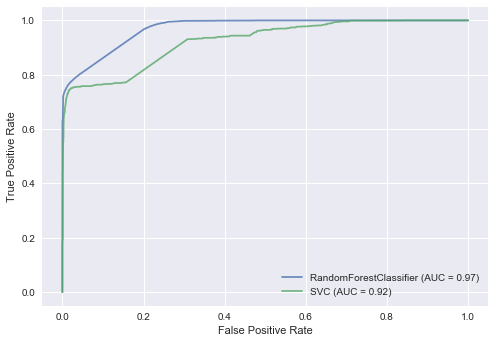

In [75]:
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve
svc = SVC(random_state=42)
svc.fit(X, y)

ax = plt.gca()
rfc_disp = plot_roc_curve(rfc, X, y, ax=ax, alpha=0.8)
# svc_disp = plot_roc_curve(svc, X, y)




svc_disp.plot(ax=ax, alpha=0.8)
plt.show()

In [124]:
print('Score: ', rfc.score(X_train, y_train))


Score:  0.9311


# beginning EDA make sure to dummyize subs

In [94]:
from collections import Counter
results = Counter()
df_entertainment['Tokelems'].apply(results.update)
# print(results)
print(len(results))

# set(['someone', 'ft.jgt', 'my', 'is', 'to', 'going', 'place', 'nickname'])

18029


In [116]:
resies = results.most_common(20)
resies = dict(resies)
resies_mod = dict()
for k, v in resies.items():
    if v<50000:
        resies_mod[k] = v

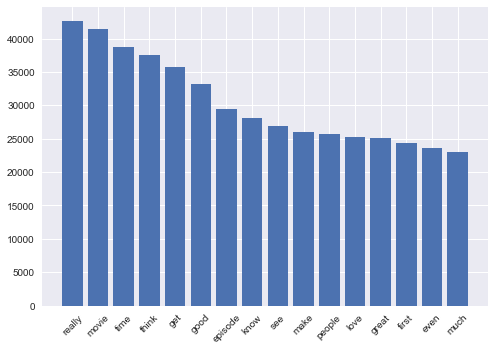

In [122]:

plt.bar(resies_mod.keys(), resies_mod.values())
plt.xticks(rotation=45)
plt.show()



In [73]:
from sklearn.feature_extraction import text
my_stop_words = list(text.ENGLISH_STOP_WORDS)
my_stop_words.append('www')
more_words_to_hate = ['http','things','thing', 'look', 'looking','lot','list','probably','just','year', 'https', 'well', 'time','like', 'maybe', 've', 'did','does', 'ca','does','got', 'times', 'would', 'need', 'actually', 'already', 'time', 'say', 'net', 'com', 'really', 
]
for i in more_words_to_hate:
    if i not in my_stop_words:
        my_stop_words.append(i)
        
        
new_stops = ['album',
 'amazing',
 'awesome',
 'bad',
 'best',
 'better',
 'bit',
 'character',
 'cool',
 'day',
 'end',
 'episode',
 'feel',
 'film',
 'going',
 'good',
 'great',
 'know',
 'life',
 'little',
 'll',
 'looks',
 'love',
 'make',
 'man',
 'music',
 'new',
 'people',
 'pretty',
 'read',
 'right',
 'saw',
 'scene',
 'seen',
 'sure',
 'think',
 'thought',
 'want',
 'wars',
 'way', 'come', 
 'jpg','10','11','12', 'amp', 'days', 'edit', 'far', 'gets', 'fun', 'getting','let', 'later', 'makes', 'men', 'na','oh', 'op', 'post', 'reddit', 'said', 'remember', 'sorry', 'start', 'started', 'stop', 'tell', 'stuff', 'took', 'try','use', 'used', 'wait', 'wanted', 'week','went', 'yeah', 'yes',
 'work',
 'world']        
        
for i in my_stop_words:
    new_stops.append(i)

In [82]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.965, min_df=.015, stop_words=new_stops)
tfidf_vectorizer.set_params(ngram_range =(1,2))
vectorized_y = tfidf_vectorizer.fit_transform(df_entertainment['Text'].values)

vectorized_y

<357672x46 sparse matrix of type '<class 'numpy.float64'>'
	with 348802 stored elements in Compressed Sparse Row format>

In [80]:
tfidf_vectorizer.fit(df_entertainment['Text'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.965,
                max_features=None, min_df=0.015, ngram_range=(1, 1), norm='l2',
                preprocessor=None, smooth_idf=True,
                stop_words=['album', 'amazing', 'awesome', 'bad', 'best',
                            'better', 'bit', 'character', 'cool', 'day', 'end',
                            'episode', 'feel', 'film', 'going', 'good', 'great',
                            'know', 'life', 'little', 'll', 'looks', 'love',
                            'make', 'man', 'music', 'new', 'people', 'pretty',
                            'read', ...],
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words=new_stops)

features = tfidf.fit_transform(df_entertainment['Text']).toarray()

labels = df_entertainment['Subreddit']
features.shape

In [67]:
# tfidf_vectorizer.get_feature_names()[vectorized_y[0].indices[1]]


In [83]:
tfidf_vectorizer.get_feature_names()

['anime',
 'big',
 'black',
 'book',
 'characters',
 'dark',
 'deadpool',
 'death',
 'definitely',
 'doing',
 'fan',
 'favorite',
 'force',
 'fuck',
 'fucking',
 'gt',
 'guess',
 'guy',
 'harry',
 'hope',
 'imgur',
 'interesting',
 'kanye',
 'kind',
 'long',
 'movie',
 'movies',
 'myanimelist',
 'nice',
 'old',
 'place',
 'point',
 'real',
 'second',
 'series',
 'shit',
 'song',
 'star',
 'story',
 'trying',
 'watch',
 'watched',
 'watching',
 'years',
 'youtube',
 'youtube watch']

In [ ]:
X = df_entertainment.drop

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.33,
                                                    random_state=0)

In [ ]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=s_stop)),
    ('clf', OneVsRestClassifier(MultinomialNB(
        fit_prior=True, class_prior=None))),])
parameters = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__estimator__alpha': (1e-2, 1e-3)}

grid_search_tune = GridSearchCV(pipeline, parameters, cv=2, n_jobs=2, verbose=3)
grid_search_tune.fit(X_train, y_train)

print("Best parameters set:")
print(grid_search_tune.best_estimator_.steps)

# NMF

In [13]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

vectorized = tfidf_vectorizer.fit_transform(clean_df2['Text'])

In [14]:
tfidf_vectorizer.get_feature_names()

['00',
 '000',
 '00000',
 '0000000031',
 '0000000642',
 '00000031',
 '00001',
 '00001001',
 '0000110',
 '00001g',
 '0001',
 '00026',
 '0004',
 '00063',
 '000bike',
 '000pull',
 '000sqft',
 '001',
 '00100000',
 '0011',
 '0015',
 '001c',
 '001jpg',
 '002',
 '003',
 '0033',
 '004',
 '005',
 '006225133476456637497',
 '007',
 '0079',
 '0080',
 '00800',
 '0088',
 '008jpg',
 '009',
 '00am',
 '00cst',
 '00gmt',
 '00pm',
 '00s',
 '01',
 '010',
 '01000001',
 '0103',
 '01100101',
 '01101000',
 '01101100',
 '01101111',
 '011915',
 '013',
 '014',
 '0140',
 '015',
 '016',
 '017',
 '01h29m41s',
 '01h41m51s',
 '01jpg',
 '01k',
 '02',
 '020',
 '021',
 '02102016',
 '0217',
 '0225',
 '0227',
 '023',
 '025',
 '028',
 '02933',
 '02937',
 '02fo',
 '02h13m39s',
 '02h26m08s',
 '03',
 '03231',
 '033',
 '0343',
 '036',
 '037',
 '038',
 '039',
 '03c12578',
 '03h10m20s',
 '03x0bu2w9hi',
 '04',
 '04042010',
 '042',
 '04e24f49b4d7b52aamp',
 '04e88fed000005dc',
 '04gif',
 '04jpg',
 '04mnf1ydnxi',
 '04putin',
 '05',


In [29]:
from sklearn.decomposition import NMF

model = NMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(vectorized)
H = model.components_

def fit_nmf(r):
    nmf = NMF(n_components=r)
    nmf.fit(vectorized)
    W = nmf.transform(vectorized)
    H = nmf.components_
    return nmf.reconstruction_err_

In [28]:
vectorized

<2497636x49076 sparse matrix of type '<class 'numpy.float64'>'
	with 34722856 stored elements in Compressed Sparse Row format>

Text(0, 0.5, 'Reconstruction Errror')

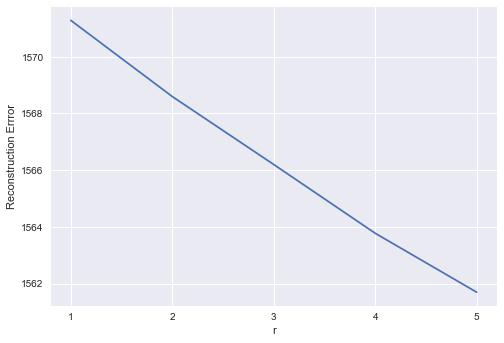

In [30]:
error = [fit_nmf(i) for i in range(1,6)]
plt.plot(range(1,6), error)
plt.xticks(range(1, 6))
plt.xlabel('r')
plt.ylabel('Reconstruction Errror')

# Random Forest 

In [46]:
clean_df = clean_df.dropna(axis=0)

In [97]:
df_select = clean_df.loc[clean_df['Subreddit'] == 'entertainment']
df_select

,Text,ID,Subreddit,meta,Time,Username,Upvotes,Downvotes,Author_link_karma,Author_Comment_Karma,Author_has_gold?
1306620,wait see whoop intergalact alien butt rogu who...,d02nuw8,movies,entertainment,1.455673e+09,cmonster1697,1.0,0.0,488.0,8426.0,0.0
1306621,amaz cinematograph best ever,d02q51i,movies,entertainment,1.455676e+09,BrodoFagginsIsMyName,1.0,0.0,1.0,457.0,0.0
1306622,final life chang,d02uuym,movies,entertainment,1.455684e+09,BrodoFagginsIsMyName,3.0,0.0,1.0,457.0,0.0
1306623,awesom thank,d02ftgc,movies,entertainment,1.455661e+09,JeopardyThis,3.0,0.0,1.0,-7.0,0.0
1306624,tom cruis charact john anderton kidnap pre-cog...,465qz3,movies,entertainment,1.455672e+09,tangowhiskey33,16.0,0.0,7346.0,6138.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1664682,love,d026lj4,harrypotter,entertainment,1.455648e+09,elbowsss,2.0,0.0,2212.0,8637.0,1.0
1664683,type ra hope manag get select current ras grea...,d02qfaf,harrypotter,entertainment,1.455677e+09,DEP61,2.0,0.0,5581.0,13488.0,0.0
1664684,bulletin board month p http iimgurcom7h3pfuyjpg,d02rem2,harrypotter,entertainment,1.455678e+09,laneebird,2.0,0.0,43.0,8.0,0.0
1664685,excel would pleas find first day great job,d02ecuj,harrypotter,entertainment,1.455659e+09,GoodniteMush,1.0,0.0,1.0,681.0,0.0


In [154]:
X = df_select.drop(['Subreddit', 'ID'], axis =1)
y = df_select['Subreddit']

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.33,
                                                    random_state=0)

In [152]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=s_stop, max_features =5000 )
vec_X_train = tfidf_vectorizer.fit_transform(X_train)
vec_X_test = tfidf_vectorizer.fit_transform(X_test)

In [153]:
# Train and fit model                                                   
rf = RandomForestClassifier(random_state=0,n_jobs=10, max_features = 'sqrt')

rf.fit(vec_X_train, y_train)
                                     
# Test Prediction
pred = rf.predict(vec_X_test)
print('Accuracy score: {:.3}'.format(rf.score(vec_X_test, y_test)))

Accuracy score: 0.224


In [ ]:
full_class_names = ['entertainment_anime.csv', 'entertainment_comicbooks.csv', 'entertainment_harrypotter.csv', 'entertainment_movies.csv', 'entertainment_music.csv', 'entertainment_starwars.csv', 'gaming_dota2.csv','gaming_gaming.csv', 'gaming_leagueoflegends.csv','gaming_minecraft.csv','gaming_pokemon.csv','gaming_skyrim.csv','gaming_starcraft.csv', 'gaming_tf2.csv','humor_adviceanimals.csv', 'humor_circlejerk.csv', 'humor_facepalm.csv','humor_funny.csv','humor_imgoingtohellforthis.csv','humor_jokes.csv', 'learning_askhistorians.csv','learning_askscience.csv','learning_explainlikeimfive.csv', 'learning_science.csv', 'learning_space.csv', 'learning_todayilearned.csv', 'learning_youshouldknow.csv', 'lifestyle_drunk.csv', 'lifestyle_food.csv', 'lifestyle_frugal.csv', 'lifestyle_guns.csv','lifestyle_lifehacks.csv','lifestyle_motorcycles.csv','lifestyle_progresspics.csv', 'lifestyle_sex.csv','news_conservative.csv','news_conspiracy.csv', 'news_libertarian.csv', 'news_news.csv','news_offbeat.csv','news_politics.csv', 'news_truereddit.csv', 'news_worldnews.csv','television_breakingbad.csv','television_community.csv', 'television_doctorwho.csv', 'television_gameofthrones.csv', 'television_himym.csv', 'television_mylittlepony.csv','television_startrek.csv', 'television_thewalkingdead.csv']


In [135]:
enter_names = ['anime', 'comicbooks', 'harrypotter', 'movies', 'music', 'starwars']



KeyError: 'anime'

In [55]:
s_stop = set(stopwords.words())
print(len(s_stop))
new_stops = ['2015ref','publisherspage190ref','volume9', 'issue2','005', '1671', '2015', 'jpgthumbemerg', 'jpgthumbrightth', 'logo', 'page7','logo.png','2015.ref', 'nameleaf200kcit','ref', '005.jpgthumbrightth', 'whose', 'kind','png', 'jpg', 'wiktionaryzero', 'wiktionaryzero0', 'wiktionaryzero0', 'articlesquantum','0supsup', '0refcit', '1-3', 'redirectzero', '.', ',', 'nameleaf200k2cit', 'wiktionari', 'namecarb01cit','-', 'filezero', 'mvaramvarxmvari', 'page98','datemfyes1915228', 'year1989ref', '1671.jpgthumbemerg', 'refimprovedatemay','ligatureligatur', 'pppc1expiry2144', 'wiktionary','wiktionary0', 'n','improvedateoctob','baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'onların', 'printr', 'sekurang', 'setidak', 'tama', 'tidaknya', 'δι', 'арбаң', 'арсалаң', 'афташ', 'бай', 'бале', 'баски', 'батыр', 'баҳри', 'болои', 'бүгжең', 'бұтыр', 'валекин', 'вақте', 'вой', 'вуҷуди', 'гар', 'гарчанде', 'далаң', 'даме', 'ербелең', 'жалт', 'жұлт', 'карда', 'кошки', 'куя', 'күңгір', 'кӣ', 'магар', 'майлаш', 'митың', 'модоме', 'нияти', 'онан', 'оре', 'паһ', 'рӯи', 'салаң', 'сар', 'сұлаң', 'сұрт', 'тарбаң', 'тразе', 'ту', 'тыржың', 'тұрс', 'хом', 'хуб', 'чаро', 'чи', 'чун', 'чунон', 'шарте', 'шұңқ', 'ыржың', 'қадар', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ', 'қош', 'қызараң', 'құйқаң', 'құлт', 'құңқ', 'ұрс', 'ҳай', 'ҳамин', 'ҳатто', 'ҳо', 'ҳол', 'ҳолате', 'әттеген', 'ӯим', 'अक', 'अग', 'अझ', 'अन', 'अर', 'आजक', 'आत', 'आद', 'आफ', 'आय', 'ईक', 'उद', 'उनक', 'उनल', 'उह', 'एउट', 'एन', 'कog', 'कत', 'कम', 'कस', 'कसर', 'कह', 'गत', 'गय', 'गर', 'चम', 'छन', 'जत', 'जबक', 'जस', 'जसक', 'जसब', 'जसम', 'जसल', 'जह', 'तत', 'तथ', 'तदन', 'तप', 'तवम', 'नज', 'नत', 'नभन', 'नय', 'पक', 'पछ', 'पन', 'पय', 'पर', 'पष', 'पह', 'बन', 'बर', 'भएक', 'भय', 'भव', 'मल', 'यत', 'यथ', 'यद', 'यप', 'यसक', 'यसपछ', 'यसब', 'यसर', 'यह', 'रण', 'रत', 'रमश', 'रह', 'लस', 'वर', 'सक', 'सट', 'सध', 'सपछ', 'सब', 'सम', 'सर', 'सह', 'हन', 'हर', 'हरण', 'ἀλλ']
for i in new_stops:
    s_stop.add(i)
    
    
print(len(s_stop))




6255
6471


In [92]:
vectorizer = CountVectorizer(stop_words=s_stop)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
y_train_vec = vectorizer.transform(y_train)
rf = RandomForestClassifier(n_estimators=,
                           max_features='auto',
                           random_state=0,
                           oob_score=True)

rf.fit(X_train_vec, y_train)
rf.oob_score_
# print("Cross Val Score: ",cross_val_score(rf,X_train_vec,y_train,cv=5).mean())
# print("Train Score: ", round(rf.score(X_train_vec,y_train)))
# print("Train Score: ", round(rf.score(X_test_vec,y_test)))
# print("Dic Size:", len(vectorizer.get_feature_names()))

ValueError: Number of labels=1673416 does not match number of samples=10

In [111]:
X = df_select['Text']
y = df_select['meta']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.33,
                                                    random_state=0)

1306620    entertainment
1306621    entertainment
1306622    entertainment
1306623    entertainment
1306624    entertainment
               ...      
1664682    entertainment
1664683    entertainment
1664684    entertainment
1664685    entertainment
1664686    entertainment
Name: meta, Length: 356493, dtype: object

In [110]:

# train = pd.read_csv('../input/train.csv').fillna(' ')
# test = pd.read_csv('../input/test.csv').fillna(' ')


KeyError: 'Text'

,Text,ID,Subreddit,meta,Time,Username,Upvotes,Downvotes,Author_link_karma,Author_Comment_Karma,Author_has_gold?
4,disclaimer : i think obama should nominate som...,d028c5d,politics,news,1.455651e+09,degausse,3.0,0.0,1.0,1941.0,0.0
6,either way the process will be dragged out unt...,d026od6,politics,news,1.455648e+09,cyberspyder,5.0,0.0,1300.0,6462.0,1.0
7,republicans have always battled with severe ca...,d026wk3,politics,news,1.455649e+09,jabb0,15.0,0.0,44981.0,141501.0,0.0
8,politics were so different back then. people o...,d02a3k3,politics,news,1.455653e+09,Hypertension123456,2.0,0.0,46.0,42036.0,0.0
9,"equally ridiculous , here 's a 1970 law review...",d025wad,politics,news,1.455647e+09,trash_reason,26.0,0.0,5613.0,1361.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2725995,for those with a woefully bad sense of directi...,d02c1s1,minecraft,gaming,1.455656e+09,capfan67,2.0,0.0,178.0,2518.0,0.0
2725996,the characters hand in first person is invisib...,464kj4,minecraft,gaming,1.455656e+09,CookiezFort,0.0,0.0,833.0,3248.0,0.0
2725997,i guess either the shaders use some feature th...,d02cxvk,minecraft,gaming,1.455657e+09,Huntron,1.0,0.0,5534.0,3062.0,1.0
2725998,my guess is that you 're trying to use a brand...,d02ic1n,minecraft,gaming,1.455664e+09,nothingl_,1.0,0.0,104.0,807.0,0.0


# EDA and Exploratory Graphs

/Users/JamesSkelton/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/JamesSkelton/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, "Histogram of users' link karma, removed outliers")

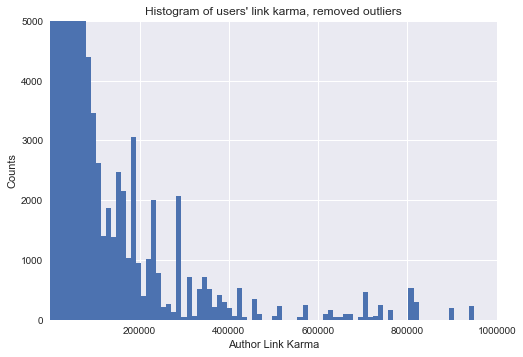

In [194]:
fig, ax = plt.subplots()
plt.hist(df.Author_link_karma, bins = 500)
plt.ylim(0, 5000)
plt.xlim(5,1000000)
ax.set_xlabel('Author Link Karma')
ax.set_ylabel('Counts')
ax.set_title("Histogram of users' link karma, removed outliers")

Text(0.5, 1.0, "Histogram of users' link karma, yscale log")

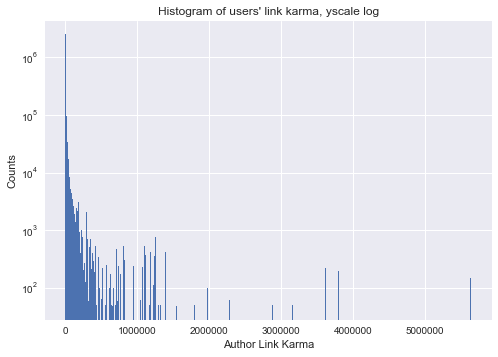

In [195]:
fig, ax = plt.subplots()
plt.hist(df.Author_link_karma, bins = 500)
# plt.ylim(0, 5000)
# plt.xlim(5,1000000)

ax.set_yscale('log')

ax.set_xlabel('Author Link Karma')
ax.set_ylabel('Counts')
ax.set_title("Histogram of users' link karma, yscale log")

Text(0.5, 1.0, "Histogram of users' link karma, outliers removed yscale log")

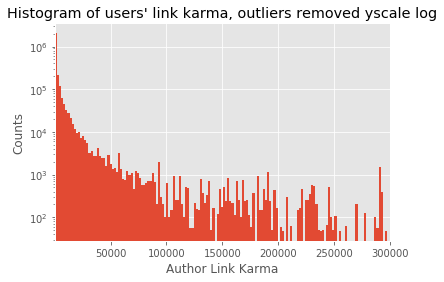

In [160]:
fig, ax = plt.subplots()
plt.hist(df.Author_link_karma, bins = 3000)
# plt.ylim()
plt.xlim(1,300000)

ax.set_yscale('log')

ax.set_xlabel('Author Link Karma')
ax.set_ylabel('Counts')
ax.set_title("Histogram of users' link karma, outliers removed yscale log")

Text(0.5, 1.0, "Histogram of users' comment karma, removed outliers")

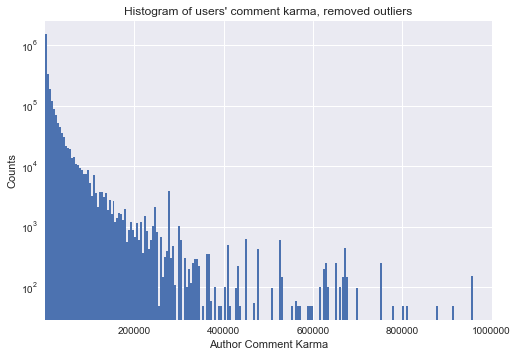

In [204]:
fig, ax = plt.subplots()
plt.hist(df.Author_Comment_Karma, bins = 500)
# plt.ylim(0, 5000)
plt.xlim(1,1000000)

ax.set_yscale('log')
ax.set_xlabel('Author Comment Karma')
ax.set_ylabel('Counts')
ax.set_title("Histogram of users' comment karma, removed outliers")

(0, 1500000)

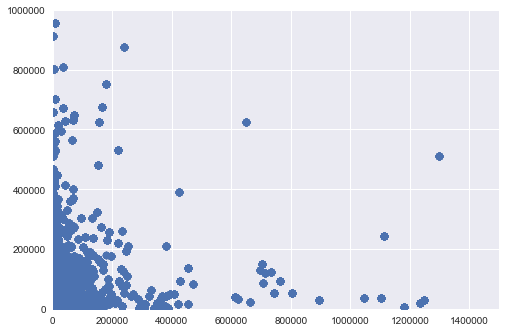

In [207]:
fig, ax = plt.subplots()

plt.scatter(df_test.Author_link_karma, df_test.Author_Comment_Karma)

# ax.set_yscale('')

ax.set_ylim(0, 1000000)
ax.set_xlim(0, 1500000)

Text(0.5, 1.0, 'Histogram of posts per hour of day')

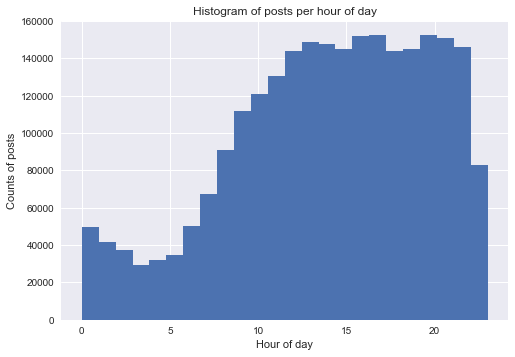

In [192]:
fig, ax = plt.subplots()

plt.hist(df_test.Time.dt.hour, bins = 24)
plt.style.use('seaborn')
ax.set_ylabel('Counts of posts')
ax.set_xlabel('Hour of day')
ax.set_title('Histogram of posts per hour of day')

In [1]:
df_test['Time'].dt.hour

NameError: name 'df_test' is not defined

In [205]:
df_test

,Text,ID,Subreddit,meta,Time,Username,Upvotes,Downvotes,Author_link_karma,Author_Comment_Karma,Author_has_gold?
4,disclaim think obama nomin someon senat hold c...,d028c5d,politics,news,2016-02-16 13:25:06,degausse,3.0,0.0,1.0,1941.0,0.0
6,either way process drag elect gop vote senat s...,d026od6,politics,news,2016-02-16 12:47:45,cyberspyder,5.0,0.0,1300.0,6462.0,1.0
7,republican alway battl sever case select amnesia,d026wk3,politics,news,2016-02-16 12:52:49,jabb0,15.0,0.0,44981.0,141501.0,0.0
8,polit differ back peopl side least pretend rea...,d02a3k3,politics,news,2016-02-16 14:04:12,Hypertension123456,2.0,0.0,46.0,42036.0,0.0
9,equal ridicul 1970 law review articl mcconnel ...,d025wad,politics,news,2016-02-16 12:30:13,trash_reason,26.0,0.0,5613.0,1361.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2725995,woefulli bad sens direct use advic hand time p...,d02c1s1,minecraft,gaming,2016-02-16 14:46:51,capfan67,2.0,0.0,178.0,2518.0,0.0
2725996,charact hand first person invis look glitchi u...,464kj4,minecraft,gaming,2016-02-16 15:01:34,CookiezFort,0.0,0.0,833.0,3248.0,0.0
2725997,guess either shader use featur ad 18 glsl vers...,d02cxvk,minecraft,gaming,2016-02-16 15:06:52,Huntron,1.0,0.0,5534.0,3062.0,1.0
2725998,guess tri use brand spank new graphic driver n...,d02ic1n,minecraft,gaming,2016-02-16 17:11:31,nothingl_,1.0,0.0,104.0,807.0,0.0


In [ ]:
import itertools

words = clean_df['Text'].str.lower().str.findall("\w+")
words = list(itertools.chain(words))
unique = set(words)
print(unique)

# PETER PREDICTIONS

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
group_names = ['Cities in USA', 'Biology', 'Articles abt Wikipedia', 'Music',
          'Cities in Japan', 'Pictures', 'Politics', 'TV & Movies',
          'Cities in USA', 'History']
with open('vectorizer.pk', 'rb') as fin:
    vectorizer = pickle.load(fin)
with open('sk_nmf.pk', 'rb') as fin:
    sk_nmf = pickle.load(fin)
print ("Please Enter Your Article:")
article = input()
my_dict = {"file_name": ["bozo.txt"], "contents": [article]}
new_df = pd.DataFrame.from_dict(my_dict)
X_new = vectorizer.transform(new_df['contents'])
W_new = sk_nmf.transform(X_new)
group_probs = W_new[0]
z = zip(group_names, group_probs)
z = sorted(z, key = lambda x: x[1], reverse=True)
for n, p in z:
    print (n + ":", p)